## Intro

A math problem which has always slightly bothered me is the [Secretary Problem](https://en.wikipedia.org/wiki/Secretary_problem). This problem can be summarised as follows:

*$n$ job seekers apply for a single position, where $n$ is a known, pre-determined integer. What is the optimal strategy for the interviewer to maximise the probability of selecting the best candidate?*

There are some extra considerations, which must be added, primarily that there is an unambiguous rating of the candidates and the interviewer, should they see all candidates, would be able to rank them from best to worst. Furthermore, after the interviewer sees a candidate, they must be immediately make a decision to either accept or reject that candidate.

You can read about this problem and its solution at length on Wikipedia in the link above -- it turns out it has a very simple and elegant solution: interview the first $n/e$ ($e$ being the base of natural logarithm, ~2.73), reject all of them and, afterwards, accept the first candidate better than all the already interviewed candidates. With this strategy, your chance of selecting the best candidate is $1/e$. This is about 37%. Pretty good, right?

Thanks to its simplicity and apparent good performance, the 37%-rule has become quite famous. But the thing which bothers me is that, in the real world, a significant portion of the elegance of this problem and its solution disappears, since:

- We often don't know how many candidates will apply.
- We might not be able to precisely rank candidates.
- We are probably not looking for the 'best' candidate -- in fact, if we are looking to fill a position, we might not even have its precise description and so it could be prudent to select someone from the top cohort, say, best 5%. Chances are, even if the selected candidate is not best-best, they might be excel in other ways. In other words, them and the position are not static and will evolve afterwards.

None of these problems are answered in the original formulation and its solution. So what can we do? We can sacrifice a part of the elegance, replace math with programming and get the answers we are looking for! This is exactly the topic of this notebook.

N.B. There will be a lot of Python code in this notebook. If Python is not your forte, don't worry! You can just skip over the code bits and read the text and look at the graphics. Or you can use this opportunity to learn more about Python programming -- I heard ChatGPT is quite good at explaining code ;-).

## Warm-up

To begin, let's look at the original solution of the Secretary Problem. The Wikipedia page already kindly provides both the mathematical formulation and its [Python implementation](https://en.wikipedia.org/wiki/Secretary_problem#cite_note-4) (I modified this a bit):

In [1]:
import numpy as np

In [2]:
# Define the function for which you want to find the maximum
def classic_dist(r, n):
    if r == 1:
        return 0
    else:
        return (r - 1) / n * np.sum([1 / (i - 1) for i in range(r, n+1)])

# Define a function to solve the problem for a specific n
def classic_solve(n):
    if n == 1:
        return 0, 1
    else:
        values = np.array([classic_dist(r, n) for r in range(1, n+1)])
        r_max = np.argmax(values) + 1
    return r_max - 1, values[r_max - 1] # we return r_max - 1 since we want to know the number of excluded candidates

classic_solve_vect = np.vectorize(classic_solve, otypes=[int, float])

What are the solutions for some values of $n$?

In [3]:
def solve_and_print(func, start_text, n, *args):
    sol = func(n, *args)
    print(start_text + f" for {n} candidates: Reject until and excluding candidate no. {sol[0]} and the probability is {(sol[1]*100):.1f}%.")

In [4]:
solve_and_print(classic_solve, "Solution", 5)
solve_and_print(classic_solve, "Solution", 20)
solve_and_print(classic_solve, "Solution", 100)
print(f"Limiting probability: {(1/np.e*100):.1f}%.")

Solution for 5 candidates: Reject until and excluding candidate no. 2 and the probability is 43.3%.
Solution for 20 candidates: Reject until and excluding candidate no. 7 and the probability is 38.4%.
Solution for 100 candidates: Reject until and excluding candidate no. 37 and the probability is 37.1%.
Limiting probability: 36.8%.


As discussed before, already with 20 candidates we are quite close to the asymptotic solution, the 37%-rule. We are also approaching this solution from above, i.e. our chance is actually **higher** than the limit.

We can also plot this function for good measure.

In [5]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

In [6]:
ns = np.arange(4,101, step=4)
stops, probs = classic_solve_vect(ns)
probs *= 100

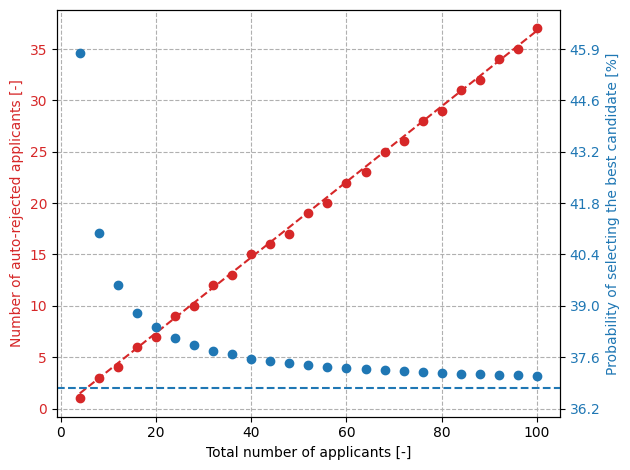

In [7]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Total number of applicants [-]')
ax1.set_ylabel('Number of auto-rejected applicants [-]', color=color)
ax1.plot(ns, stops, 'o', color=color)
ax1.plot(ns, ns/np.e, color=color, ls='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Probability of selecting the best candidate [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(ns, probs, 'o', color=color)
ax2.axhline(100/np.e, color=color, linestyle='--', label='1/e')
ax2.set_ylim([36,47])
ax2.tick_params(axis='y', labelcolor=color)

# Align grid lines
# credit to https://stackoverflow.com/questions/48090998/double-y-axis-with-matching-gridlines
ylim1 = ax1.get_ylim()
len1 = ylim1[1]-ylim1[0]
yticks1 = ax1.get_yticks()
rel_dist = [(y-ylim1[0])/len1 for y in yticks1]
ylim2 = ax2.get_ylim()
len2 = ylim2[1]-ylim2[0]
yticks2 = [ry*len2+ylim2[0] for ry in rel_dist]

ax2.set_yticks(yticks2)
ax2.set_ylim(ylim2)
ax1.yaxis.grid(which="major", linestyle='--')
ax1.xaxis.grid(which="major", linestyle='--')

def format_ticks(x, pos):
    return f'{x:.1f}'  # Format to one decimal place

# Apply custom formatting function to x-axis ticks
ax2.yaxis.set_major_formatter(FuncFormatter(format_ticks))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Quite nice! The dots in the above plot are the solutions to the problem for various total numbers of candidates -- red (left axis) is the number of candidates to auto-reject $r$ (and then select the first one better than all previous afterwards) and blue (right axis) the probability of picking the best candidate with this strategy. The red dashed line is the asymptotic solution $r = n/e$ and the blue dashed line the asymptotic probability $1/e \approx 37\%$.

Now, before we start modifying the problem, we need to see if we can replicate the above solution directly from the problem definition, rather than using mathematical formulae. Since we are dealing with randomness and probability, we can approach the challenge statistically. To that end, we first need:

- A function able to generate a random ordering of candidates given a number of candidates $n$.
- A function returning True/False for a given ordering of candidates and a given rejection stopping number $r$. In this context, 'True' means we have succesfully selected the best candidate and 'False', well, we have not.

In [8]:
# since we are dealing with floats, I haphazardly ignore the case where some numbers are the same
def random_ordering(n):
    return np.random.rand(n)

In [9]:
print(random_ordering(5))

[0.34602104 0.04605595 0.22681323 0.34579988 0.38194954]


In [10]:
def selection_success(ordering, r):
    n = ordering.size
    best_overall = np.max(ordering)
    r = max(0, min(r, n))
    best_rejected = np.max(ordering[:r]) if r > 0 else 0
    remain = ordering[r:]
    higher_indices = remain > best_rejected
    select = remain[np.argmax(higher_indices)] if np.any(higher_indices) else 0
    return select == best_overall

Just briefly, the function in the code above takes an ordering and a rejection stopping number, finds the overall best candidate, the best candidate among the rejected ones; then it goes through the candidates which have not been rejected and selects the first one better than all previous. It finally returns 'True' if this selected candidate is the overall best candidate and 'False' otherwise.

With this function available, we can for example choose $n$ and $r$, generate a sample of, say, 100 000 orderings and see what is the proportion of successfully selecting the best candidate.

In [11]:
n_test = 50
r_test, prob_test = classic_solve(n_test)

sampling_size = 100_000
proportion = sum([selection_success(random_ordering(n_test), r_test) for _ in range(sampling_size)])/sampling_size

print(proportion, prob_test)

0.37592 0.37427501364792015


The first number is the one calculated by our method. Note that we have selected the *r_test* proposed as optimal by the theoretical solution -- it is therefore no surprise that our predicted proportion is very close to the theoretical probability (the second printed number). That means, simply, that the sample mean is close to the population mean. It also means our code works (although it seems we need quite a large number of samples to be reliably close to the theoretical solution)!

Of course, we are cheating a little bit here -- we are already pre-selecting the optimal $r$. In reality, we need to go through one extra step and write the function in a way that the $r$ is also an output of our solver. We can do it by generating many orderings and test all values of $r$ to see if it would lead to an optimal selection; by doing this many times and averaging the result, we can then conclude on both the probability of selection and $r$.

In [12]:
def numeric_solve_1(n):
    ordering = random_ordering(n)
    best_overall = np.max(ordering)
    evals = np.zeros(n, dtype=bool)
    best_rejected = 0
    for r in range(n):
        if r > 0 and ordering[r-1] > best_rejected:
            best_rejected = ordering[r-1]
        remain = ordering[r:]
        higher_indices = remain > best_rejected
        select = remain[np.argmax(higher_indices)] if np.any(higher_indices) else 0
        evals[r] = (select == best_overall)
    return evals

def numeric_solve(n, sampling):
    evals = np.zeros(n, dtype=float)
    for _ in range(sampling):
        evals += numeric_solve_1(n)

    evals /= sampling

    max_idx = np.argmax(evals)
    return max_idx, evals[max_idx]

Not the most efficient code, especially with Python, but it will do.

In [13]:
n_test = 30
sampling_size = 100_000

solve_and_print(classic_solve, "Theoretical solution", n_test)
solve_and_print(numeric_solve, "Numerical solution", n_test, sampling_size)

Theoretical solution for 30 candidates: Reject until and excluding candidate no. 11 and the probability is 37.9%.
Numerical solution for 30 candidates: Reject until and excluding candidate no. 10 and the probability is 38.0%.


If we run this code for different values of *n_test*, we discover a couple of things:

- The code is quite slow in executing for high values of *n_test*. If we ever wanted to evaluate this many times over and over, we should optimize the implementation. By the way, if you have come up with an optimized implementation, let me know! I would be happy to improve the implementation.
- For higher values of $n$ ($\sim30$ and higher), the numerical solution often returns a different value of $r$. That is not a bug: with 100 000 evaluations, we have quite a large sample! This means that the exact value of $r$ stops mattering so much when we get to such $n$'s. But importantly, the probability is still quite close to be within a third significant digit.
- For $n=2$, the numerical solver sometimes returns 0 and sometimes 1. Of course it does -- the chance is 50% in this case. The theoretical solution returns always 1, but there is no real reason why it has to. It could also return 0! This is quite obvious in hindsight, but interesting nonetheless.

## First extension

So what have we actually achieved so far? Our solver is slow and less reliable than the theoretical solution -- why did we even bother with it? Well, with the basic machinery in place, we can now start modifying the problem and try to resolve the issues I have listed in the Introduction.

The first one I will look at is our ability to gauge the candidates. What if we are actually not able to assess candidate's abilities perfectly? How will that decrease our chance to find the best one? Well, this would be quite a headache to solve with theory... But it turns out that in our framework it is as simple as making the processing of each ordering a bit fuzzy! Note that for zero uncertainty, the below code reduces into the above one.

*Sidebar:* Throughout this notebook, I am assuming uniformly distributed random numbers. Feel free to swap this for your distribution of choice. And let me know if any of the conclusions change! 

In [14]:
def uncertain_numeric_solve_1(n, uncertainty):
    ordering = random_ordering(n)
    # best overall is selected with the exact ordering
    best_overall = np.max(ordering)
    # now we switch to a fuzzy ordering
    fuzzy_ordering = ordering + uncertainty * random_ordering(n)
    
    evals = np.zeros(n, dtype=bool)
    best_rejected = 0

    for r in range(n):
        if r > 0 and fuzzy_ordering[r-1] > best_rejected:
            best_rejected = fuzzy_ordering[r-1]
        remain = fuzzy_ordering[r:]
        higher_indices = remain > best_rejected
        # we need to modify the actual comparison
        if np.any(higher_indices):
            select_idx = r + np.argmax(higher_indices)
            evals[r] = (ordering[select_idx] == best_overall)
        else:
            evals[r] = False
    return evals

def uncertain_numeric_solve(n, sampling, uncertainty):
    evals = np.zeros(n, dtype=float)
    for _ in range(sampling):
        evals += uncertain_numeric_solve_1(n, uncertainty)

    evals /= sampling

    max_idx = np.argmax(evals)
    return max_idx, evals[max_idx]

In [61]:
n_test = 20
sampling_size = 100_000

solve_and_print(classic_solve, "Theoretical solution", n_test)
solve_and_print(numeric_solve, "Numerical solution", n_test, sampling_size)
uncertainty_p = 5
solve_and_print(uncertain_numeric_solve, f"{uncertainty_p}%-uncertain solution", n_test, sampling_size, uncertainty_p/100)
uncertainty_p = 10
solve_and_print(uncertain_numeric_solve, f"{uncertainty_p}%-uncertain solution", n_test, sampling_size, uncertainty_p/100)

Theoretical solution for 20 candidates: Reject until and excluding candidate no. 7 and the probability is 38.4%.
Numerical solution for 20 candidates: Reject until and excluding candidate no. 7 and the probability is 38.6%.
5%-uncertain solution for 20 candidates: Reject until and excluding candidate no. 7 and the probability is 34.9%.
10%-uncertain solution for 20 candidates: Reject until and excluding candidate no. 7 and the probability is 31.9%.


Cool! We see for 20 candidates that by being 5% uncertain (note that this uncertainty is defined with respect to the theoretical maximum, i.e. 1), our chance in finding the best candidate drops by about 3.5%; for 10% the reduction is about 6.5%. These reduction values are quite consistent if you run this code cell multiple times. So, let's plot this over the whole range from 1 to 100! Note that the below code cell will run for quite some time. I know, I know, should have optimized it! If you are following along but don't want to wait, you can just download representative data in a cell bit below.

In [22]:
ns = np.arange(4,101, step=4)

classic_stops, classic_probs = classic_solve_vect(ns)
classic_probs *= 100

In [ ]:
numerical_stops, numerical_probs = np.zeros(ns.shape,dtype=int), np.zeros(ns.shape,dtype=float)
uncertain_5_stops, uncertain_5_probs = np.zeros(ns.shape,dtype=int), np.zeros(ns.shape,dtype=float)
uncertain_10_stops, uncertain_10_probs = np.zeros(ns.shape,dtype=int), np.zeros(ns.shape,dtype=float)

for i,n in enumerate(ns):
    numerical_stops[i], numerical_probs[i] = numeric_solve(n, sampling_size)
    uncertain_5_stops[i], uncertain_5_probs[i] = uncertain_numeric_solve(n, sampling_size, 0.05)
    uncertain_10_stops[i], uncertain_10_probs[i] = uncertain_numeric_solve(n, sampling_size, 0.1)

numerical_probs *= 100
uncertain_5_probs *= 100
uncertain_10_probs *= 100

Since it took so long, I am going to store those precious arrays.

In [17]:
import json
import requests

In [ ]:
# Convert the arrays to lists
numerical_stops_list = numerical_stops.tolist()
numerical_probs_list = numerical_probs.tolist()
uncertain_5_stops_list = uncertain_5_stops.tolist()
uncertain_5_probs_list = uncertain_5_probs.tolist()
uncertain_10_stops_list = uncertain_10_stops.tolist()
uncertain_10_probs_list = uncertain_10_probs.tolist()

# Create a dictionary to hold the arrays
data = {
    "numerical_stops": numerical_stops_list,
    "numerical_probs": numerical_probs_list,
    "uncertain_5_stops": uncertain_5_stops_list,
    "uncertain_5_probs": uncertain_5_probs_list,
    "uncertain_10_stops": uncertain_10_stops_list,
    "uncertain_10_probs": uncertain_10_probs_list
}

# Write the data to a JSON file
with open("part_1_results.json", "w") as json_file:
    json.dump(data, json_file)

Here is the download method.

In [33]:
def load_json_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        try:
            json_data = json.loads(response.text)
            return json_data
        except json.JSONDecodeError as e:
            print("Error decoding JSON:", e)
            return None
    else:
        print("Failed to load JSON from URL:", url)
        return None

url = "https://raw.githubusercontent.com/tannhorn/some-notebooks/main/secretary_problem/part_1_results.json"
data = load_json_from_url(url)
if data:
    print("JSON data loaded successfully.")
else:
    print("Failed to load JSON data from URL")

# Convert the lists back to NumPy arrays
numerical_stops = np.array(data["numerical_stops"])
numerical_probs = np.array(data["numerical_probs"])
uncertain_5_stops = np.array(data["uncertain_5_stops"])
uncertain_5_probs = np.array(data["uncertain_5_probs"])
uncertain_10_stops = np.array(data["uncertain_10_stops"])
uncertain_10_probs = np.array(data["uncertain_10_probs"])
rel_uncertain_5_stops = np.array(data["rel_uncertain_5_stops"])
rel_uncertain_5_probs = np.array(data["rel_uncertain_5_probs"])
rel_uncertain_10_stops = np.array(data["rel_uncertain_10_stops"])
rel_uncertain_10_probs = np.array(data["rel_uncertain_10_probs"])

JSON data loaded successfully.


No matter how you got them, let's see how the results look like!

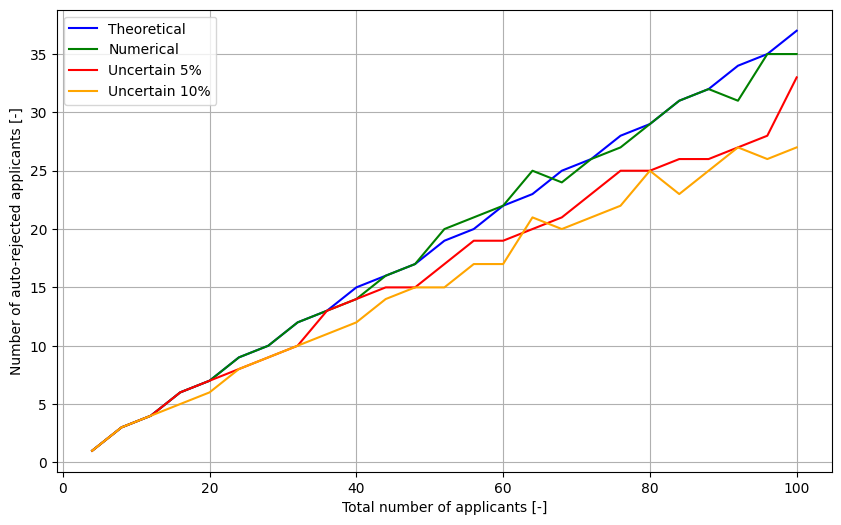

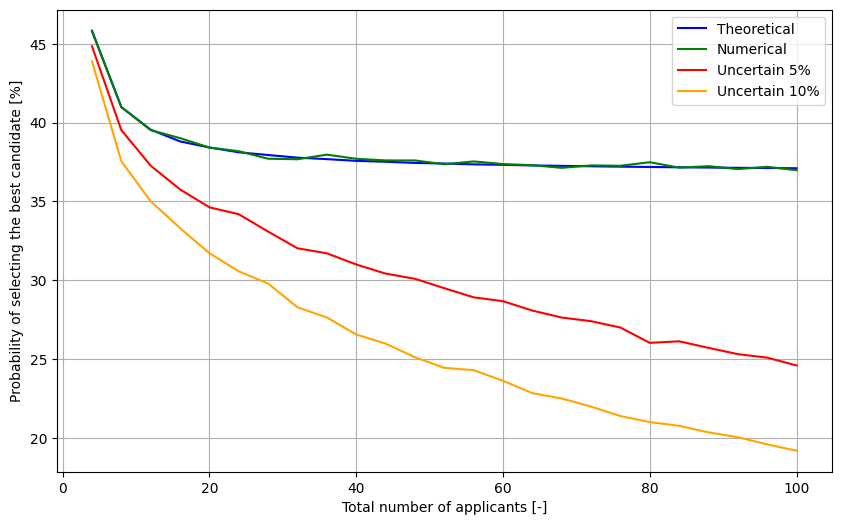

In [29]:
# Plotting stops
plt.figure(figsize=(10, 6))
plt.plot(ns, classic_stops, label='Theoretical', color='blue')
plt.plot(ns, numerical_stops, label='Numerical', color='green')
plt.plot(ns, uncertain_5_stops, label='Uncertain 5%', color='red')
plt.plot(ns, uncertain_10_stops, label='Uncertain 10%', color='orange')
plt.xlabel('Total number of applicants [-]')
plt.ylabel('Number of auto-rejected applicants [-]')
plt.legend()
plt.grid(True)
plt.show()

# Plotting probs
plt.figure(figsize=(10, 6))
plt.plot(ns, classic_probs, label='Theoretical', color='blue')
plt.plot(ns, numerical_probs, label='Numerical', color='green')
plt.plot(ns, uncertain_5_probs, label='Uncertain 5%', color='red')
plt.plot(ns, uncertain_10_probs, label='Uncertain 10%', color='orange')
plt.xlabel('Total number of applicants [-]')
plt.ylabel('Probability of selecting the best candidate [%]')
plt.legend()
plt.grid(True)
plt.show()

The blue and green curves are very close to each other (as they should) but that is about the only good news we have. The moment we have included uncertainty, our chance of selecting the best candidate is dropping catastrophically with increasing $n$ -- it does seem that there is an asymptotic value (I will leave that to be figured out by a better mathematician than me) but, in any case, it is quite a low value. Even if we are just a 5% uncertain about the performance of a candidate, the 37%-rule has become quite-less-than-30%-rule if the number of candidates exceeds 50!

Before we reach any hasty conclusions, we should scrutinize our assumption that the uncertainty is additive. Let's see if the conclusions change with multiplicative uncertainty, i.e. if our ability to evaluate the candidate is dependent on the ability of the candidate themselves. In reality, neither fully additive nor fully multiplicative model are representative but we should make sure that our choice of one or the other does not impact the overall picture.

In [30]:
def rel_uncertain_numeric_solve_1(n, uncertainty):
    ordering = random_ordering(n)
    # best overall is selected with the exact ordering
    best_overall = np.max(ordering)
    # now we switch to a fuzzy ordering
    fuzzy_ordering = ordering * (1 + uncertainty * random_ordering(n))
    
    evals = np.zeros(n, dtype=bool)
    best_rejected = 0

    for r in range(n):
        if r > 0 and fuzzy_ordering[r-1] > best_rejected:
            best_rejected = fuzzy_ordering[r-1]
        remain = fuzzy_ordering[r:]
        higher_indices = remain > best_rejected
        # we need to modify the actual comparison
        if np.any(higher_indices):
            select_idx = r + np.argmax(higher_indices)
            evals[r] = (ordering[select_idx] == best_overall)
        else:
            evals[r] = False
    return evals

def rel_uncertain_numeric_solve(n, sampling, uncertainty):
    evals = np.zeros(n, dtype=float)
    for _ in range(sampling):
        evals += rel_uncertain_numeric_solve_1(n, uncertainty)

    evals /= sampling

    max_idx = np.argmax(evals)
    return max_idx, evals[max_idx]

In [69]:
rel_uncertain_5_stops, rel_uncertain_5_probs = np.zeros(ns.shape,dtype=int), np.zeros(ns.shape,dtype=float)
rel_uncertain_10_stops, rel_uncertain_10_probs = np.zeros(ns.shape,dtype=int), np.zeros(ns.shape,dtype=float)

for i,n in enumerate(ns):
    rel_uncertain_5_stops[i], rel_uncertain_5_probs[i] = rel_uncertain_numeric_solve(n, sampling_size, 0.05)
    rel_uncertain_10_stops[i], rel_uncertain_10_probs[i] = rel_uncertain_numeric_solve(n, sampling_size, 0.1)

rel_uncertain_5_probs *= 100
rel_uncertain_10_probs *= 100

Same book-keeping as above:

In [31]:
# Convert the arrays to lists
numerical_stops_list = numerical_stops.tolist()
numerical_probs_list = numerical_probs.tolist()
uncertain_5_stops_list = uncertain_5_stops.tolist()
uncertain_5_probs_list = uncertain_5_probs.tolist()
uncertain_10_stops_list = uncertain_10_stops.tolist()
uncertain_10_probs_list = uncertain_10_probs.tolist()
rel_uncertain_5_stops_list = rel_uncertain_5_stops.tolist()
rel_uncertain_5_probs_list = rel_uncertain_5_probs.tolist()
rel_uncertain_10_stops_list = rel_uncertain_10_stops.tolist()
rel_uncertain_10_probs_list = rel_uncertain_10_probs.tolist()

# Create a dictionary to hold the arrays
data = {
    "numerical_stops": numerical_stops_list,
    "numerical_probs": numerical_probs_list,
    "uncertain_5_stops": uncertain_5_stops_list,
    "uncertain_5_probs": uncertain_5_probs_list,
    "uncertain_10_stops": uncertain_10_stops_list,
    "uncertain_10_probs": uncertain_10_probs_list,
    "rel_uncertain_5_stops": rel_uncertain_5_stops_list,
    "rel_uncertain_5_probs": rel_uncertain_5_probs_list,
    "rel_uncertain_10_stops": rel_uncertain_10_stops_list,
    "rel_uncertain_10_probs": rel_uncertain_10_probs_list
}

# Write the data to a JSON file
with open("part_1_results.json", "w") as json_file:
    json.dump(data, json_file)

Let's plot again!

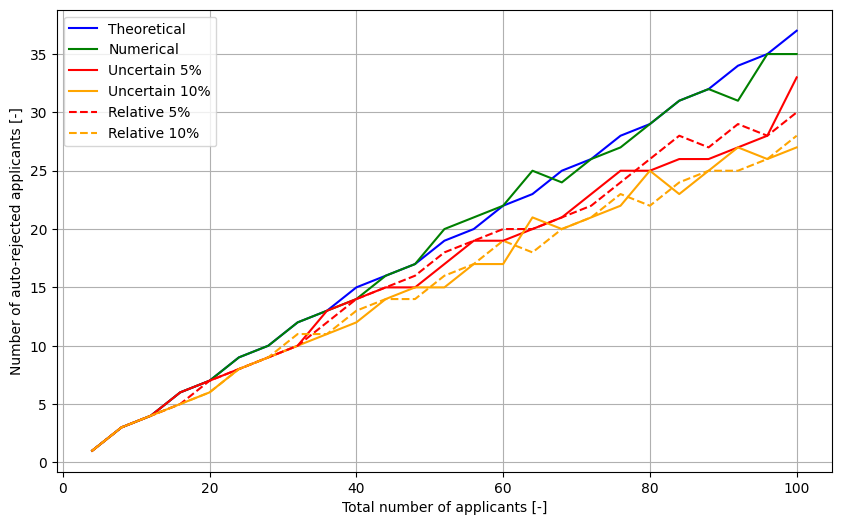

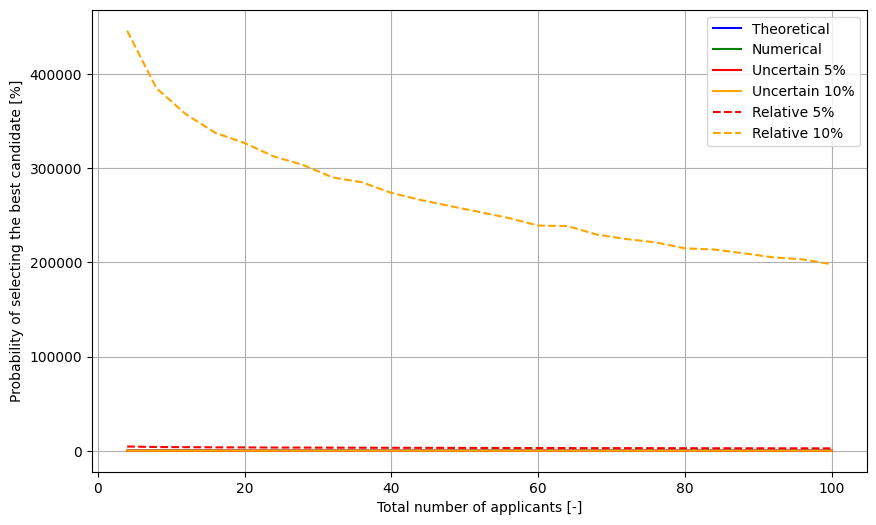

In [34]:
# Plotting stops
plt.figure(figsize=(10, 6))
plt.plot(ns, classic_stops, label='Theoretical', color='blue')
plt.plot(ns, numerical_stops, label='Numerical', color='green')
plt.plot(ns, uncertain_5_stops, label='Uncertain 5%', color='red')
plt.plot(ns, uncertain_10_stops, label='Uncertain 10%', color='orange')
plt.plot(ns, rel_uncertain_5_stops, label='Relative 5%', color='red', ls='--')
plt.plot(ns, rel_uncertain_10_stops, label='Relative 10%', color='orange', ls='--')
plt.xlabel('Total number of applicants [-]')
plt.ylabel('Number of auto-rejected applicants [-]')
plt.legend()
plt.grid(True)
plt.show()

# Plotting probs
plt.figure(figsize=(10, 6))
plt.plot(ns, classic_probs, label='Theoretical', color='blue')
plt.plot(ns, numerical_probs, label='Numerical', color='green')
plt.plot(ns, uncertain_5_probs, label='Uncertain 5%', color='red')
plt.plot(ns, uncertain_10_probs, label='Uncertain 10%', color='orange')
plt.plot(ns, rel_uncertain_5_probs, label='Relative 5%', color='red', ls='--')
plt.plot(ns, rel_uncertain_10_probs, label='Relative 10%', color='orange', ls='--')
plt.xlabel('Total number of applicants [-]')
plt.ylabel('Probability of selecting the best candidate [%]')
plt.legend()
plt.grid(True)
plt.show()